In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
from datasets import Dataset, load_dataset
from lime import lime_image
from skimage.segmentation import mark_boundaries
from torch.utils.data import DataLoader
from transformers import AdamW, ViTForImageClassification, ViTImageProcessor


In [2]:
model_checkpoint = "google/vit-base-patch16-224-in21k"

processor = ViTImageProcessor.from_pretrained(model_checkpoint)
image_mean = processor.image_mean
image_std = processor.image_std
size = processor.size["height"]


In [3]:
path = os.path.join(os.getcwd(), "images")
full_dataset = load_dataset("imagefolder", data_dir=path, drop_labels=False)

Found cached dataset imagefolder (/home/juan/.cache/huggingface/datasets/imagefolder/default-9159a25992f991f7/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


  0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
id2label = {id:label for id, label in enumerate(full_dataset['train'].features['label'].names)}
label2id = {v: k for k, v in id2label.items()}
id2label

{0: 'NORMAL', 1: 'PNEUMONIA'}

In [5]:


class ViTLightningModule(pl.LightningModule):
    def __init__(self, num_labels=2):
        super(ViTLightningModule, self).__init__()
        self.vit = ViTForImageClassification.from_pretrained(model_checkpoint,
                                                              num_labels=2,
                                                              id2label=id2label,
                                                              label2id=label2id)

    def forward(self, pixel_values):
        outputs = self.vit(pixel_values=pixel_values)
        return outputs.logits
        
    def common_step(self, batch, batch_idx):
        pixel_values = batch['pixel_values']
        labels = batch['labels']
        logits = self(pixel_values)

        criterion = nn.CrossEntropyLoss()
        loss = criterion(logits, labels)
        predictions = logits.argmax(-1)
        correct = (predictions == labels).sum().item()
        accuracy = correct/pixel_values.shape[0]

        return loss, accuracy
      
    def training_step(self, batch, batch_idx):
        loss, accuracy = self.common_step(batch, batch_idx)     
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_loss", loss)
        self.log("training_accuracy", accuracy)

        return loss
    
    def validation_step(self, batch, batch_idx):
        loss, accuracy = self.common_step(batch, batch_idx)     
        self.log("validation_loss", loss, on_epoch=True)
        self.log("validation_accuracy", accuracy, on_epoch=True)

        return loss

    def test_step(self, batch, batch_idx):
        loss, accuracy = self.common_step(batch, batch_idx)     
        self.log("test_loss", loss, on_epoch=True)
        self.log("test_accuracy", accuracy, on_epoch=True)

        return loss

    def configure_optimizers(self):
        # We could make the optimizer more fancy by adding a scheduler and specifying which parameters do
        # not require weight_decay but just using AdamW out-of-the-box works fine
        return torch.optim.AdamW(self.parameters(), lr=5e-5)

    # def train_dataloader(self):
    #     return train_dataloader

    # def val_dataloader(self):
    #     return val_dataloader

    # def test_dataloader(self):
    #     return test_dataloader

In [6]:
model = ViTLightningModule().to("cuda")
model.load_state_dict(torch.load("./ViT_ChestXRay_2Classes.pt"))


Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

In [7]:
from datasets import Dataset, load_dataset
import os

path = os.path.join(os.getcwd(), "images")
full_dataset = load_dataset("imagefolder", data_dir=path, drop_labels=False)


Found cached dataset imagefolder (/home/juan/.cache/huggingface/datasets/imagefolder/default-9159a25992f991f7/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


  0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
from torchvision.transforms import (CenterCrop, 
                                    Compose, 
                                    Normalize, 
                                    RandomHorizontalFlip,
                                    RandomResizedCrop, 
                                    Resize, 
                                    ToTensor)

normalize = Normalize(mean=image_mean, std=image_std)
_train_transforms = Compose(
        [
            RandomResizedCrop(size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(size),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

In [9]:
full_dataset["train"].set_transform(val_transforms)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


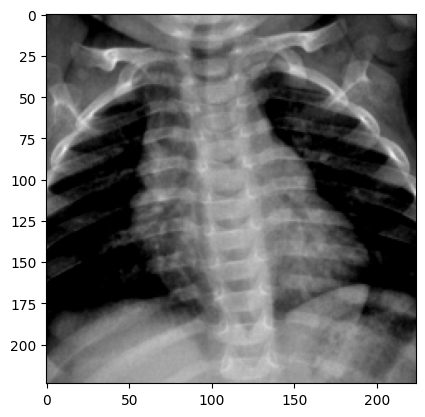

In [10]:
plt.imshow(np.transpose(full_dataset["train"][0]["pixel_values"].numpy(), (1, 2, 0)))
plt.show()

In [11]:
test = full_dataset["train"][0]["pixel_values"].unsqueeze(0).to("cuda")

F.softmax(model(test), dim=-1)


tensor([[0.9875, 0.0125]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [23]:
import gc
del model
torch.cuda.empty_cache()
gc.collect()


NameError: name 'model' is not defined

In [18]:
model.eval()

def predict(input):
    input = torch.from_numpy(input.transpose(0, 3, 1, 2)).to("cuda")

    pred = model(input)
    del input

    pred = F.softmax(pred, dim=-1).cpu().detach().numpy()

    return pred
    

explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(
    full_dataset["train"][1]["pixel_values"].numpy().transpose(1, 2, 0),
    predict,
    top_labels=2,
    hide_color=0,
    num_samples=1000,
    batch_size=20,
)



  0%|          | 0/1000 [00:00<?, ?it/s]

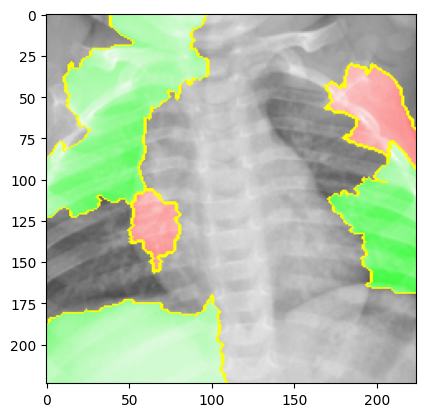

In [19]:
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=False,
    num_features=10,
    hide_rest=False,
)

plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.show()